In [21]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import glob
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torchvision.utils import save_image
import torch.nn as nn
from torch.autograd import Variable
from glob import glob
import os
import torch

Création du dataset, on va chercher toutes les images avec l'extension jpg. Puis on applique un mask blanc au centre de l'image, pour cacher le visage.
On applique les transformations nécessaire à l'image.

On retourne l'image d'origine, l'image avec le mask, et le mask, et le coordonnée sup gauche du masque

In [22]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode = "train"):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.image_files = glob(os.path.join(root_dir, '*.jpg'))

    def random_mask(self, img, image_size = 128, mask_size = 64):
        i = np.random.randint(0, image_size /2)
        masked_part = img[:, i : i + mask_size, i : i + mask_size]
        masked_img = img.clone()
        masked_img[:, i : i + mask_size, i : i + mask_size] = 1
        return masked_img, masked_part, i

    def create_mask(self, img, image_size = 128, mask_size = 64):
        i = (image_size - mask_size) // 2
        masked_part = img[:,32:96,32:96]
        masked_img = img.clone()
        masked_img[:, i : i + mask_size, i : i + mask_size] = 1

        return masked_img, masked_part, i

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path)
        if(self.mode == "train"):
            if self.transform:
                image = self.transform(image)
            mask, aux, i = self.random_mask(image)
        else : 
            if self.transform:
                image = self.transform(image)
            mask, aux, i = self.create_mask(image)
        return image, mask, aux, i


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [4]:
batch_size = 16
dataset = CustomDataset(root_dir='./img_align_celeba/', transform=transform)
validation_dataset = CustomDataset(root_dir="./validation_dataset/", transform=transform, mode="val")
test_dataset = CustomDataset(root_dir='./test_dataset/', transform=transform, mode="test")

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [5]:
len(test_dataset)

11

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

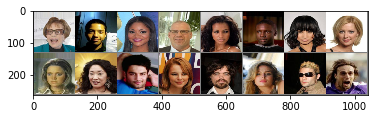

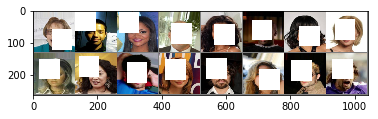

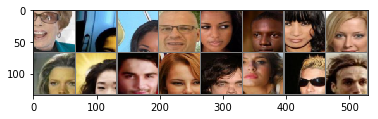

In [7]:
dataiter = iter(dataloader)

images, masked_images, mask, i = next(dataiter)
n_batches = len(dataiter)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(masked_images))
imshow(torchvision.utils.make_grid(mask))

### GAN

Le generateur est composé de deux parties. Il prend en entrée une image et la transforme en une représentation latente à l'aide de couches de convolution (down) et de transposition (up).

L'encodage de l'image en un vecteur latent se fait via les couches 1 à 5, qui réduisent la dimension de l'image d'un facteur 2. Augmente le nombre de channels pour arriver à 512 channels. Puis on passe la sortie à une couche de convolution pour produire le vecteur latent de l'image de taille (4000, 4, 4).

Ensuite on agrandit l'image et on réduit le nombre de channel avec la batch normalisation et la fonction d'activation ReLU().

Au final, on utilise la fonction d'activation Tanh pour normaliser la sortie entre -1 et 1, pour les pixels de l'images normalisés.

In [8]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        self.downsample_1 = nn.Conv2d(channels, 64, 4, stride=2, padding=1)
        self.downsample_2 = nn.Sequential(
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2)
        )
        self.downsample_3 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2)
        )
        self.downsample_4 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2)
        )
        self.downsample_5 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2)
        )

        self.conv = nn.Conv2d(512, 4000, 1)

        self.upsample_1 = nn.Sequential(
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.ReLU()
        )
        self.upsample_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU()
        )
        self.upsample_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU()
        )
        self.upsample_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU()
        )

        self.final_conv = nn.Conv2d(64, channels, 3, stride=1, padding=1)

        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.downsample_1(x)
        x = self.downsample_2(x)
        x = self.downsample_3(x)
        x = self.downsample_4(x)
        x = self.downsample_5(x)
        # shape de x est 512,4,4
        x = self.conv(x)
        #shape de x est 4000, 4, 4
        x = self.upsample_1(x)
        x = self.upsample_2(x)
        x = self.upsample_3(x)
        x = self.upsample_4(x)

        x = self.final_conv(x)
        x = self.activation(x)

        return x       


La classe discriminateur permet de distinguer les images générées par le générateur des images réelles.

Le discriminant est construit avec une série de couches de convolution qui réduisent progressivement la taille de l'image d'entrée tout en augmentant le nombre de canaux. La dernière couche de convolution réduit finalement la sortie à une seule valeur, qui représente la probabilité que l'image d'entrée soit réelle ou générée.

In [9]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

Cette fonction initialise les poids et les biais du réseau de neurones de manière aléatoire, en utilisant une distribution normale avec une moyenne de 0 et un écart type de 0.02 pour les couches de convolution. Si le module est une couche de normalisation de batch, la fonction initialise les poids avec une valeur de 1 et les biais avec une valeur de 0. Cette initialisation est utilisée car elle permet une normalisation rapide et efficace des activations de la couche, ce qui peut améliorer les performances du modèle en évitant la saturation et en accélérant la convergence de l'apprentissage.

Cette initialisation permet de rendre l'entrainement plus stable, en évitant les valeurs initiales extrêmes qui pourraient empêcher la convergence.

In [10]:
def latent_vector(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
n_epochs = 100
lr = 0.0002

generator = Generator()
discriminator = Discriminator()

# Initialize weights
generator.apply(latent_vector)
discriminator.apply(latent_vector)

g_optimizer = torch.optim.Adam(generator.parameters(), lr = lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr =lr)

adv_loss = torch.nn.MSELoss()
pix_loss = torch.nn.L1Loss()

Ici on enregistre les images reconstruites 

In [12]:
def save_images(batches_done, loader):
    samples, masked_samples, mask, i = next(iter(loader))
    i = i[0].item()
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + 64, i : i + 64] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "./images/%d.png" % batches_done, nrow=6, normalize=True)


In [13]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [14]:
# Calculate output of image discriminator (PatchGAN)
patch_h, patch_w = int(64 / 2 ** 3), int(64 / 2 ** 3)
patch = (1, patch_h, patch_w)
print(patch)

(1, 8, 8)


Nous allons maintenant entrainer le modèle encodeur-decodeur / discriminateur.

Le modèle Encodeur est utilisé pour générer une partie manquante des images masquées et le Discriminateur est utilisé pour classer les parties manquantes générées (d_part) et les vraies images (t).
Le modèle Encodeur est entraîné en minimisant une perte d'adversaire (g_adv) et une perte de pixel (g_pix). La perte totale du générateur (g_loss) est calculée comme une combinaison pondérée des deux pertes. Les gradients sont ensuite calculés par rétropropagation et les poids du générateur (encodeur) sont mis à jour avec l'optimiseur g_optimizer.

Le Discriminateur est également entraîné à distinguer les vraies images des images générées. La perte totale du discriminateur (d_loss) est calculée comme la moyenne pondérée des pertes pour les vraies images et les images générées. Les gradients sont calculés et les poids du discriminateur (Discriminator) sont mis à jour avec l'optimiseur d_optimizer.

In [15]:
generator.load_state_dict(torch.load("./modeles/generator_gan.pth", map_location=torch.device('cuda')))
discriminator.load_state_dict(torch.load("./modeles/discriminator_gan.pth", map_location=torch.device('cuda')))

FileNotFoundError: [Errno 2] No such file or directory: './modeles/generator_gan.pth'

In [ ]:
for epoch in range(n_epochs):
    for i, (images, masked, t, n) in enumerate(dataloader):
        reals = Variable(Tensor(images.shape[0], *patch).fill_(1.0), requires_grad=False)
        fakes = Variable(Tensor(images.shape[0], *patch).fill_(0.0), requires_grad=False)

        images = Variable(images.type(Tensor))
        masked = Variable(masked.type(Tensor))
        t = Variable(t.type(Tensor))

        g_optimizer.zero_grad()

        #on génere un batch de masques 
        gen_parts = generator(masked)

        #les loss
        d_part = discriminator(gen_parts)
        #print(d_part)
        #moyenne des carrées des différences entre pixels
        g_adv = adv_loss(d_part,reals)
        #v.a des différences entre pixel
        g_pix = pix_loss(gen_parts, t)
        
        #loss total
        g_loss = 0.001 * g_adv + 0.999 * g_pix

        d_x = d_part.mean().item()

        g_loss.backward()
        g_optimizer.step()


        # ici on entraine le discriminateur
        d_optimizer.zero_grad()

        #on entraine le discri pour qu'il capte quelles sont les images réelles et générées
        d_part = discriminator(t)
        real_loss = adv_loss(d_part, reals)
        d_gen = discriminator(gen_parts.detach())
        fake_loss = adv_loss(d_gen, fakes)

        d_loss = 0.5 *(real_loss + fake_loss)

        d_gz1 = d_gen.mean().item()
        d_gz2 = d_part.mean().item()

        d_loss.backward()
        d_optimizer.step()

        print(f"epoch {epoch} / {n_epochs}, d_loss = {d_loss.item()},g_adv = {g_adv.item()}, D(x) = {d_x}, d(G(z)) = {d_gz1} / {d_gz2} ")

        save_images(epoch, dataloader)

        if i == (len(dataloader)-1):
            save_images(epoch, dataloader)

In [ ]:
torch.save(generator.state_dict(), "generator_gan.pth")
torch.save(discriminator.state_dict(), "discriminator_gan.pth")

### Test validation 

In [ ]:
save_images(epoch, val_dataloader)
save_images(epoch, test_dataloader)